In [1]:
import numpy as np
import pandas as pd
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt

%matplotlib inline
from IPython.display import display
pd.options.display.max_rows = 100
pd.options.display.max_columns = None

import seaborn as sns
sns.set()

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_original=pd.read_csv("c:/data/bank-additional-full.csv",sep=';')
df_original=df_original.drop(['duration'],axis=1) # Per instructions from UC Irvine 
df_original.loc[df_original.pdays == 999, 'pdays'] = np.nan # 999 = No data from UCI.
df = df_original.copy()

print(df.shape)
display(df.head())

(41188, 20)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
def extended_describe(df):
    de = df.describe()

    nu = pd.DataFrame(df.nunique())
    nu.columns = ['nunique']
    nu = nu.transpose()

    nan = pd.DataFrame(df.isnull().sum(axis=0))
    nan.columns = ['nan']
    nan = nan.transpose()

    de = de.append([nu, nan], sort=False).transpose()
    de['categorical'] = de['count'].isnull()
    de.index.name = 'column'
    return de

In [4]:
de = extended_describe(df)
de

,count,mean,std,min,25%,50%,75%,max,nunique,nan,categorical
column,,,,,,,,,,,
age,41188.0,40.024060,10.421250,17.000,32.000,38.000,47.000,98.000,78.0,0.0,False
campaign,41188.0,2.567593,2.770014,1.000,1.000,2.000,3.000,56.000,42.0,0.0,False
pdays,1515.0,6.014521,3.824906,0.000,3.000,6.000,7.000,27.000,26.0,39673.0,False
previous,41188.0,0.172963,0.494901,0.000,0.000,0.000,0.000,7.000,8.0,0.0,False
emp.var.rate,41188.0,0.081886,1.570960,-3.400,-1.800,1.100,1.400,1.400,10.0,0.0,False
cons.price.idx,41188.0,93.575664,0.578840,92.201,93.075,93.749,93.994,94.767,26.0,0.0,False
cons.conf.idx,41188.0,-40.502600,4.628198,-50.800,-42.700,-41.800,-36.400,-26.900,26.0,0.0,False
euribor3m,41188.0,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045,316.0,0.0,False
nr.employed,41188.0,5167.035911,72.251528,4963.600,5099.100,5191.000,5228.100,5228.100,11.0,0.0,False


In [5]:
numeric_columns = list(de.loc[de.categorical == False].reset_index()['column'])
categorical_columns = list(de.loc[de.categorical == True].reset_index()['column'])
# print(numeric_columns, categorical_columns)

## Outliers
Looking at the 25th percential and the min, as well as the 75th percential and the max, the data does not have any extreams that need to delt with

## Null Values
Only pdays (days since last phone contact) has null values.  In the origional dataset, this was set to 999, but was changed to nan after load.  The far majority of the values are null.  

### pdays
The output variable is the column **y** (did the prospect sign up for a term deposit).  So lets see if pdays has a signifigant corrlation of to the output variable.

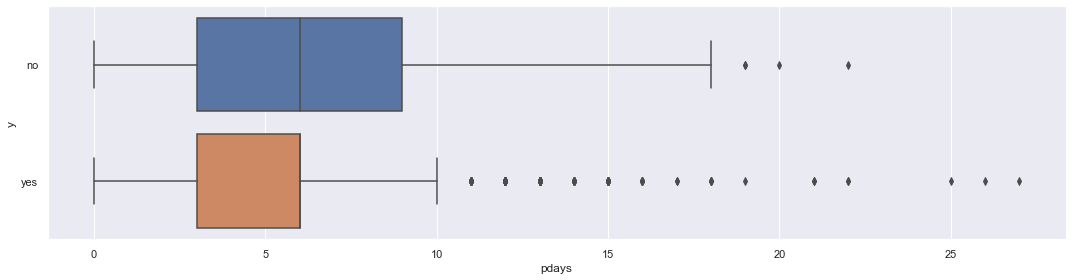

In [6]:
f = plt.figure(figsize=(15, 4))
sns.boxplot(x=df['pdays'], y=df['y'])
f.tight_layout()
plt.show()

The positive outcomes have a shorter **pdays** value.  So lets keep the feature, but convert it to a categorical column and drop the numeric column.

In [7]:
pdays_columns = ['no_contact', 'contact_0_5', 'contact_5_10', 'contact_10_15', 'contact_20']

df[pdays_columns[0]] = 0
df[pdays_columns[0]][df.pdays.isnull()] = 1

df[pdays_columns[1]] = 0
df[pdays_columns[1]][df.pdays <= 5] = 1

df[pdays_columns[2]] = 0
df[pdays_columns[2]][(df.pdays > 5) & (df.pdays <= 10)] = 1

df[pdays_columns[3]] = 0
df[pdays_columns[3]][(df.pdays > 15) & (df.pdays <= 20)] = 1

df[pdays_columns[4]] = 0
df[pdays_columns[4]][df.pdays > 20] = 1
                                     
df.drop('pdays', axis=1, inplace=True);
numeric_columns.remove('pdays')
categorical_columns = categorical_columns + pdays_columns

In [8]:
categorical_columns_sans_pdays = [c for c in categorical_columns if c not in pdays_columns]
for col in categorical_columns_sans_pdays:
    display(pd.DataFrame(df[col].value_counts()))

,job
admin.,10422
blue-collar,9254
technician,6743
services,3969
management,2924
retired,1720
entrepreneur,1456
self-employed,1421
housemaid,1060
unemployed,1014


,marital
married,24928
single,11568
divorced,4612
unknown,80


,education
university.degree,12168
high.school,9515
basic.9y,6045
professional.course,5243
basic.4y,4176
basic.6y,2292
unknown,1731
illiterate,18


,default
no,32588
unknown,8597
yes,3


,housing
yes,21576
no,18622
unknown,990


,loan
no,33950
yes,6248
unknown,990


,contact
cellular,26144
telephone,15044


,month
may,13769
jul,7174
aug,6178
jun,5318
nov,4101
apr,2632
oct,718
sep,570
mar,546
dec,182


,day_of_week
thu,8623
mon,8514
wed,8134
tue,8090
fri,7827


,poutcome
nonexistent,35563
failure,4252
success,1373


,y
no,36548
yes,4640


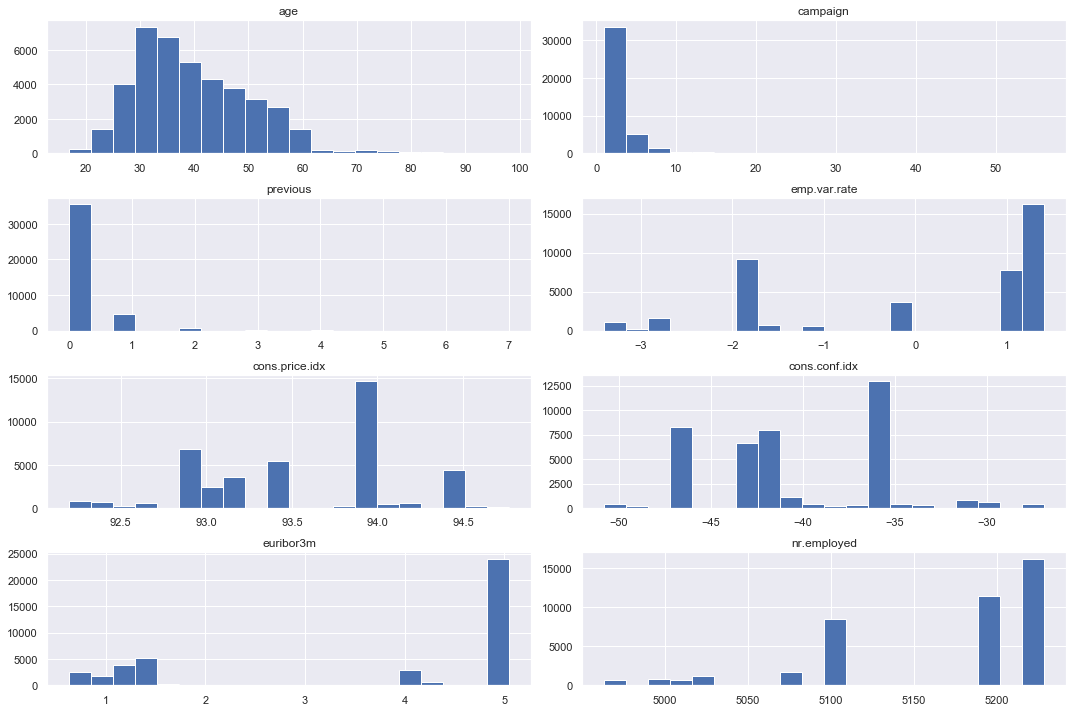

In [9]:
i = 0
j = 0
row_count = len(numeric_columns) // 2
f = plt.figure(figsize=(15, 10))
gs = f.add_gridspec(row_count, 2)

for col in numeric_columns:
    ax = f.add_subplot(gs[i, j])
    ax.hist(df[col], bins=20)
    ax.set_title(col)
    if j == 1:
        j = 0
        i += 1
    else:
        j += 1

f.tight_layout()
plt.show()

In [10]:
df_clean = pd.get_dummies(df)

In [11]:
def getScaledDataFrame(df):
    mms = MinMaxScaler()
    mms.fit(df)

    result = pd.DataFrame(mms.transform(df))
    result.columns = df.columns
    result.index = df.index
    return result

df_clean = getScaledDataFrame(df_clean)

In [12]:
extended_describe(df_clean)

,count,mean,std,min,25%,50%,75%,max,nunique,nan,categorical
column,,,,,,,,,,,
age,41188.0,0.284248,0.128657,0.0,0.185185,0.259259,0.370370,1.0,78.0,0.0,False
campaign,41188.0,0.028502,0.050364,0.0,0.000000,0.018182,0.036364,1.0,42.0,0.0,False
previous,41188.0,0.024709,0.070700,0.0,0.000000,0.000000,0.000000,1.0,8.0,0.0,False
emp.var.rate,41188.0,0.725393,0.327283,0.0,0.333333,0.937500,1.000000,1.0,10.0,0.0,False
cons.price.idx,41188.0,0.535723,0.225581,0.0,0.340608,0.603274,0.698753,1.0,26.0,0.0,False
cons.conf.idx,41188.0,0.430854,0.193648,0.0,0.338912,0.376569,0.602510,1.0,26.0,0.0,False
euribor3m,41188.0,0.677237,0.393210,0.0,0.160961,0.957379,0.980957,1.0,316.0,0.0,False
nr.employed,41188.0,0.769134,0.273163,0.0,0.512287,0.859735,1.000000,1.0,11.0,0.0,False
no_contact,41188.0,0.963217,0.188230,0.0,1.000000,1.000000,1.000000,1.0,2.0,0.0,False


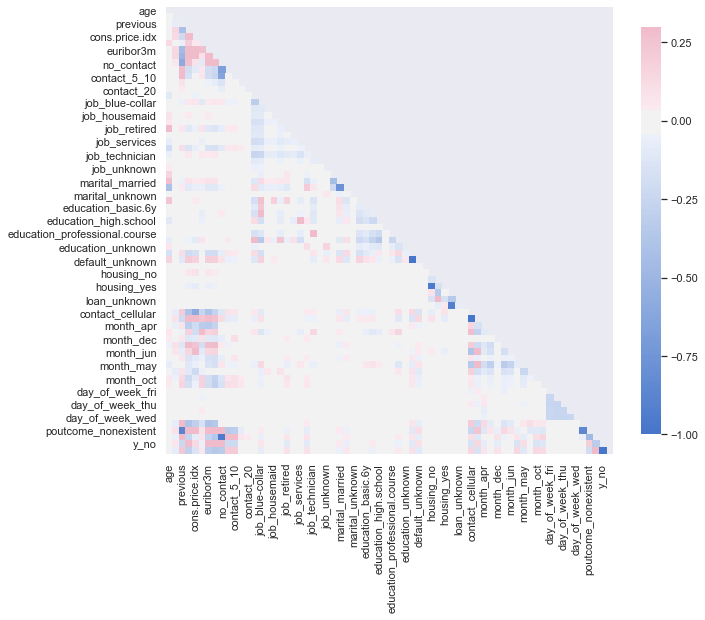

In [13]:
corr = df_clean.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(255, 0, as_cmap=True)

f = plt.figure(figsize=(10, 10))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, cbar_kws={"shrink": .75})

## Split into Train and Test

In [14]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_clean, 
                               train_size=0.8, 
                               stratify=df_clean.y_yes.values, 
                               random_state=42)

print('Means of Positive Output Variable\nOriginal: {:.6f}\nTrain: {:.6f}\nTest: {:.6f}'.format(
                                                                                (df_clean.y_yes).mean(), 
                                                                                (train.y_yes).mean(),
                                                                                (test.y_yes).mean()))
print('\nRowCounts\nTrain: {:,}\nTest: {:,}'.format(len(train), len(test)))

feature_columns = df_clean.columns[0:len(df_clean.columns) - 2] #Remove both y_yes and y_no
x_train = train[feature_columns].copy()
y_train = train['y_yes'].copy()
x_test = test[feature_columns].copy()
y_test = test['y_yes'].copy()

Means of Positive Output Variable
Original: 0.112654
Train: 0.112656
Test: 0.112649

RowCounts
Train: 32,950
Test: 8,238


In [15]:
logit = LogisticRegression(C=1, class_weight={1:2}, random_state = 42, solver='saga')
logit.fit(x_train, y_train)
print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

Coefficient: 
 [[-4.27337847e-02 -2.10109430e+00 -6.24828332e-01 -5.12135774e+00
   3.63003996e+00  5.07594867e-01  8.57023747e-01  3.13164367e-01
  -1.18290286e+00  3.52748494e-02  1.11877132e-01 -8.91650576e-01
   5.85148328e-01 -1.18374408e-02 -1.34083934e-01 -2.49656702e-02
  -8.57257044e-02 -1.80815661e-02  3.30629572e-01 -4.23734330e-02
  -1.42859827e-01  1.55714000e-01 -5.51100727e-03 -4.72377990e-02
   5.51129992e-02 -1.57024050e-01 -9.12730796e-02 -1.21527610e-02
   2.89230080e-01 -1.28426082e-01  4.42700334e-02 -1.68278112e-01
  -1.00664221e-01  5.38819000e-01 -1.28425576e-01 -2.60556388e-02
  -2.45921390e-03  2.26181221e-01 -3.72831517e-03 -1.93672716e-01
   3.51856471e-02  1.65586232e-02 -2.29640806e-02 -7.36271153e-03
   1.65586232e-02  1.95842780e-02  3.24570074e-01 -2.95789885e-01
  -1.01387189e-01  2.55465111e-01  3.43053759e-01  2.54108207e-02
  -4.79531639e-01  1.19288731e+00 -6.03396606e-01 -5.20327513e-01
  -3.65672985e-02 -4.68265612e-02  8.47360527e-03 -1.71770903

In [16]:
y_pred = logit.predict(x_train)
y_pred_proba = logit.predict_proba(x_train)

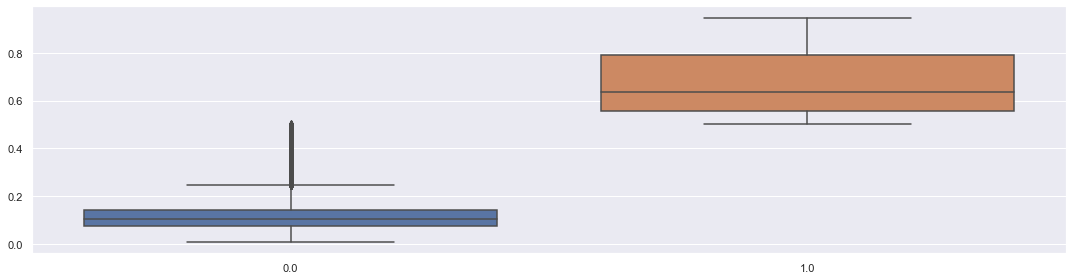

In [17]:
y_pred_proba_viz = [i[1] for i in y_pred_proba]
f = plt.figure(figsize=(15, 4))
sns.boxplot(y=y_pred_proba_viz, x=y_pred)
f.tight_layout()
plt.show()

In [18]:
print('Accuracy: {:%}'.format(logit.score(x_train, y_train)))
print('\n', confusion_matrix(y_train, y_pred))
print('\n', classification_report(y_train, y_pred))

Accuracy: 88.910470%

 [[27820  1418]
 [ 2236  1476]]

               precision    recall  f1-score   support

         0.0       0.93      0.95      0.94     29238
         1.0       0.51      0.40      0.45      3712

    accuracy                           0.89     32950
   macro avg       0.72      0.67      0.69     32950
weighted avg       0.88      0.89      0.88     32950



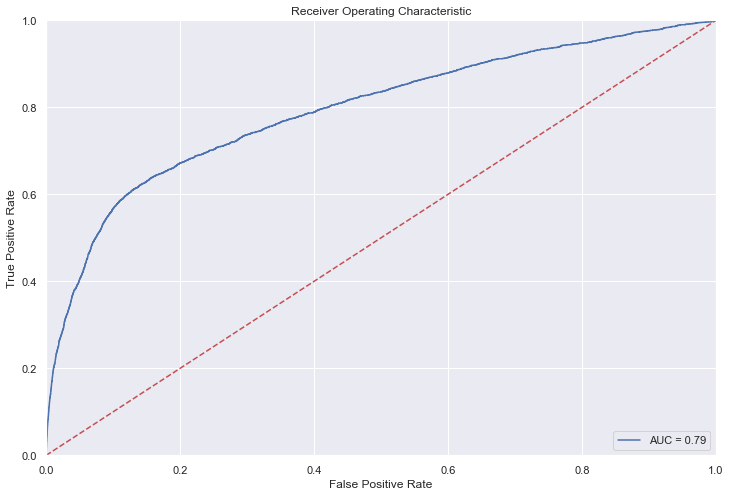

In [19]:
fpr, tpr, threshold = metrics.roc_curve(y_train, y_pred_proba[:, 1])
roc_auc = metrics.auc(fpr, tpr)

f = plt.figure(figsize=(12, 8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()